# Bandit Sequence Design

Design 60 6-base RBS sequences based on the bandit recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from sklearn.manifold import TSNE
import seaborn as sns
from itertools import product
import math

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,TTAAGTAAGCGGGGAAAATA,57706.0,NaN,AAGTAAGCGGGGA,NaN
1,ACGATCTTAAGTAGACGCGGAAAATAATG,TTAAGTAGACGCGGAAAATA,613.0,NaN,AAGTAGACGCGGA,NaN
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,TTAAGTAAGCGCGGAAAATA,5313.0,NaN,AAGTAAGCGCGGA,NaN
3,ACGATCTTAAGTAAACGAGGAAAATAATG,TTAAGTAAACGAGGAAAATA,19594.0,NaN,AAGTAAACGAGGA,NaN
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,TTAAGTAGGCGAGGAAAATA,33626.0,NaN,AAGTAGGCGAGGA,NaN


In [3]:
df = df.drop_duplicates(subset = ['B', 'C'])
df.shape

(113, 6)

In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [5]:
data = np.asarray(normalize(df)[['B', 'C']])
data.shape

(113, 2)

## Construct feature spaces

would be 'AAGT' + 6-base + 'GGA' 

@Maciej: to determine the seq other than the 6-base.

In [6]:
# create all combos


combos = []
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in product(char_sets, repeat= design_len):
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len

In [7]:
todesign_data = np.asarray(list(zip(combos, labels)))

## Setting


In [8]:
embedding = 'label'
kernel = [DotProduct()]
string_kernel_flag = False

## Recommendations with GPUCB

/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


60
[ 895 2875 2819 1819  887  307  939  563   35  299   43  295  371  315
 2859 2847  883  383   39 2871  375  303 2587  443 2867  831  827   19
  803  775  807 2839  815 2835  287   23  819  811  783  555  771   31
  279  547  551  543  823  275  779 2843  559   27  283  531  535  539
  791  799  787  795]


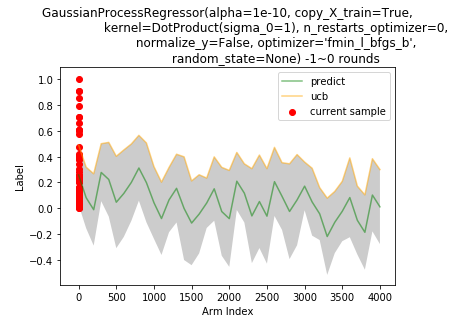

In [9]:
num_rounds = 1
num_exper = 1
num_rec = 60

my_env = Rewards_env(data, embedding)
new_env = Rewards_env(todesign_data, embedding)
if string_kernel_flag:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel[-1])))
else:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = kernel[-1]))
rec_arms = agent.play(label_avaiable = False)

## Similarity vs Prediction

In [10]:
all_data = np.concatenate((data, todesign_data))
all_env = Rewards_env(all_data, embedding)
if len(kernel) == 1:
    kernel_matrix = kernel[0].__call__(all_env.embedded)
else:
    kernel_matrix = kernel[0](all_data[:,0])

In [11]:
kernel_matrix

array([[ 62.,  56.,  60., ...,  56.,  54.,  58.],
       [ 56.,  59.,  55., ...,  53.,  51.,  55.],
       [ 60.,  55.,  59., ...,  53.,  51.,  55.],
       ...,
       [ 56.,  53.,  53., ..., 109., 107., 111.],
       [ 54.,  51.,  51., ..., 107., 106., 108.],
       [ 58.,  55.,  55., ..., 111., 108., 114.]])

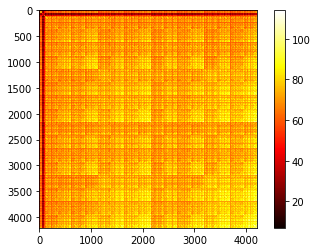

In [12]:
plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
plt.colorbar()
plt.show()

### TSNE

In [13]:
tsne = TSNE(metric = 'precomputed')
X_embedded = tsne.fit_transform(kernel_matrix)

In [14]:
X_embedded

array([[ 0.07486231, -0.0088403 ],
       [-0.01229822, -0.080437  ],
       [ 0.04768857, -0.04639014],
       ...,
       [-2.572079  , -1.1766497 ],
       [-2.593068  , -0.8348966 ],
       [-2.4931924 , -1.5040624 ]], dtype=float32)

In [50]:
similar_seqs = []

for i, idx_i in enumerate(X_embedded[113:]):
    for j, idx_j in enumerate(X_embedded[:113]):
        if np.linalg.norm(X_embedded[i]- X_embedded[j]) ** 2 <= 0.01:
            similar_seqs.append(i)
            break

In [57]:
len_sim = len(similar_seqs)
len_sim

In [52]:
similar_seqs = np.asarray(similar_seqs)

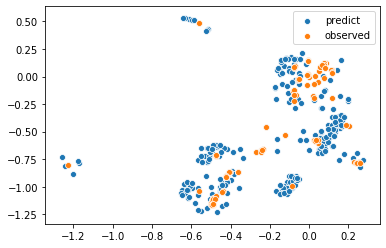

In [53]:
sns.scatterplot(X_embedded[similar_seqs, 0], X_embedded[similar_seqs,1], legend='full', label = 'predict')
sns.scatterplot(X_embedded[:113,0], X_embedded[:113,1], legend='full', label = 'observed')

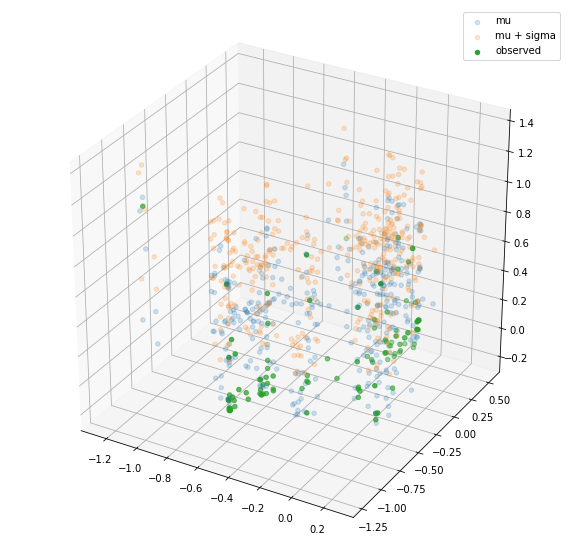

In [60]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
#X, Y = np.meshgrid(X_embedded[similar_seqs,0], X_embedded[similar_seqs,1])
#ax.plot_surface(X,Y, agent.mu[similar_seqs].reshape(len_sim,1), label = 'mu', rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
ax.scatter3D(X_embedded[similar_seqs,0], X_embedded[similar_seqs,1], agent.mu[similar_seqs], label = 'mu', alpha = 0.2)
ax.scatter3D(X_embedded[similar_seqs,0], X_embedded[similar_seqs,1], (agent.mu + agent.sigma)[similar_seqs], label = 'mu + sigma', alpha = 0.2)
ax.scatter3D(X_embedded[:113,0], X_embedded[:113,1], list(all_data[:113,1]), label = 'observed')
plt.legend()
plt.show()

### Convert to RBS seq

In [17]:
todesign_data[np.asarray(rec_arms),0]

array(['TTTAAGAATGTTTTATACAT', 'TTTAAGACTATCTTATACAT',
       'TTTAAGACTAAATTATACAT', 'TTTAAGAGTAGCTTATACAT',
       'TTTAAGAATGTGTTATACAT', 'TTTAAGAAGATATTATACAT',
       'TTTAAGAATCCCTTATACAT', 'TTTAAGAACATATTATACAT',
       'TTTAAGAAAACATTATACAT', 'TTTAAGAAGACCTTATACAT',
       'TTTAAGAAAACCTTATACAT', 'TTTAAGAAGACGTTATACAT',
       'TTTAAGAAGGTATTATACAT', 'TTTAAGAAGATCTTATACAT',
       'TTTAAGACTACCTTATACAT', 'TTTAAGACTAGTTTATACAT',
       'TTTAAGAATGTATTATACAT', 'TTTAAGAAGGTTTTATACAT',
       'TTTAAGAAAACGTTATACAT', 'TTTAAGACTATGTTATACAT',
       'TTTAAGAAGGTGTTATACAT', 'TTTAAGAAGACTTTATACAT',
       'TTTAAGACCAGCTTATACAT', 'TTTAAGAAGCTCTTATACAT',
       'TTTAAGACTATATTATACAT', 'TTTAAGAATATTTTATACAT',
       'TTTAAGAATATCTTATACAT', 'TTTAAGAAAAGATTATACAT',
       'TTTAAGAATACATTATACAT', 'TTTAAGAATAAGTTATACAT',
       'TTTAAGAATACGTTATACAT', 'TTTAAGACTAGGTTATACAT',
       'TTTAAGAATACTTTATACAT', 'TTTAAGACTAGATTATACAT',
       'TTTAAGAAGAGTTTATACAT', 'TTTAAGAAAAGGTTATACAT',
       'TT

In [18]:
'''
onehot_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]
onehot_dict = {'1000': 'A',
               '0100': 'C',
               '0010': 'G',
               '0001': 'T'}

rbs_seqs = []

for seq in onehot_seqs:
    rbs_seq = []
    for i in range(int(len(seq)/4)):
        start = i * 4
        end = start + 4
        s = seq[start:end]
        rbs_seq.append(onehot_dict[s])
    rbs_seq = ''.join(rbs_seq)
    rbs_seqs.append(rbs_seq)
    
rbs_seqs
'''

"\nonehot_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]\nonehot_dict = {'1000': 'A',\n               '0100': 'C',\n               '0010': 'G',\n               '0001': 'T'}\n\nrbs_seqs = []\n\nfor seq in onehot_seqs:\n    rbs_seq = []\n    for i in range(int(len(seq)/4)):\n        start = i * 4\n        end = start + 4\n        s = seq[start:end]\n        rbs_seq.append(onehot_dict[s])\n    rbs_seq = ''.join(rbs_seq)\n    rbs_seqs.append(rbs_seq)\n    \nrbs_seqs\n"